<a href="https://colab.research.google.com/github/SergeySmalkov/Detector/blob/main/Perudo_Binance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython.core.display import display, HTML
from scipy import signal
from numba import jit
from datetime import timedelta
from bisect import bisect_left
pd.set_option('mode.chained_assignment', None)
from math import exp


In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
binance = pd.read_pickle('drive/MyDrive/crypto_research/binance')
binance_trades = pd.read_pickle('drive/MyDrive/crypto_research/trades_Binance')

In [97]:
# Function to get the best bid
def get_best_bid(bids):
    # The best bid is the highest price in the bids list
    # Bids list is formatted as [(price, volume),...]
    # So, we sort by price in descending order and take the first element
    best_bid = sorted(bids, key=lambda x: x[0], reverse=True)[0][0]
    return best_bid

# Function to get the best ask
def get_best_ask(asks):
    # The best ask is the lowest price in the asks list
    # Asks list is formatted as [(price, volume),...]
    # So, we sort by price in ascending order and take the first element
    best_ask = sorted(asks, key=lambda x: x[0])[0][0]
    return best_ask

# Apply these functions to your DataFrame
binance['best_bid'] = binance['bids'].apply(get_best_bid)
binance['best_ask'] = binance['asks'].apply(get_best_ask)

# The mid point of ToB is the average of the best bid and best ask
binance['mid_ToB'] = (binance['best_bid'] + binance['best_ask']) / 2
binance = binance.drop(['symbol', 'market'], axis=1)
binance

,receive_timestamp,asks,bids,best_bid,best_ask,mid_ToB
0,2023-06-13 00:00:00.259,"[(15.2, 4847.01), (15.21, 6739.28)]","[(15.18, 2076.81), (15.17, 4800.05), (15.16, 7...",15.18,15.20,15.190
1,2023-06-13 00:00:00.657,"[(15.2, 4866.34), (15.21, 6730.65), (15.23, 18...","[(15.18, 2262.12), (15.17, 4800.05), (15.16, 7...",15.18,15.20,15.190
2,2023-06-13 00:00:00.759,"[(15.2, 4866.34), (15.21, 6730.65), (15.22, 97...","[(15.18, 2393.78), (15.17, 4800.05), (15.16, 7...",15.18,15.20,15.190
3,2023-06-13 00:00:00.963,"[(15.2, 2501.53), (15.21, 5931.88), (15.22, 89...","[(15.18, 2413.53), (15.17, 4800.05), (15.16, 6...",15.18,15.20,15.190
4,2023-06-13 00:00:01.058,"[(15.19, 100.4), (15.2, 3200.77), (15.21, 6013...","[(15.18, 2413.53), (15.17, 4740.74), (15.16, 6...",15.18,15.19,15.185
...,...,...,...,...,...,...
427037,2023-06-13 23:59:59.193,"[(15.04, 3005.95), (15.05, 3160.6), (15.06, 79...","[(15.03, 588.84), (15.02, 2836.04), (15.01, 49...",15.03,15.04,15.035
427038,2023-06-13 23:59:59.392,"[(15.04, 3004.95), (15.05, 3160.6), (15.06, 79...","[(15.03, 588.84), (15.02, 2836.04), (15.01, 49...",15.03,15.04,15.035
427039,2023-06-13 23:59:59.692,"[(15.04, 3001.38), (15.05, 3160.6), (15.06, 79...","[(15.03, 588.84), (15.02, 2836.04), (15.01, 49...",15.03,15.04,15.035
427040,2023-06-13 23:59:59.791,"[(15.04, 3001.38), (15.05, 2918.0), (15.06, 79...","[(15.03, 422.53), (15.02, 2836.04), (15.01, 49...",15.03,15.04,15.035


In [98]:
binance_trades = binance_trades.drop(['symbol', 'market', 'outer_id'], axis=1)
binance_trades

,price,amount,maker_side,market_timestamp,receive_timestamp
0,15.19,7.03,Ask,2023-06-13 00:00:01.066,2023-06-13 00:00:01.196
1,15.19,0.40,Ask,2023-06-13 00:00:04.710,2023-06-13 00:00:04.839
2,15.19,0.27,Ask,2023-06-13 00:00:04.710,2023-06-13 00:00:04.840
3,15.19,1.50,Ask,2023-06-13 00:00:05.503,2023-06-13 00:00:05.632
4,15.20,1.91,Ask,2023-06-13 00:00:05.503,2023-06-13 00:00:05.633
...,...,...,...,...,...
137377,15.04,13.29,Ask,2023-06-13 23:59:31.610,2023-06-13 23:59:31.740
137378,15.04,0.44,Ask,2023-06-13 23:59:53.601,2023-06-13 23:59:53.731
137379,15.04,8.54,Ask,2023-06-13 23:59:55.627,2023-06-13 23:59:55.757
137380,15.03,0.89,Bid,2023-06-13 23:59:57.511,2023-06-13 23:59:57.641


In [99]:
# Ensure the 'receive_timestamp' and 'market_timestamp' columns are in datetime format
binance['receive_timestamp'] = pd.to_datetime(binance['receive_timestamp'])
binance_trades['receive_timestamp'] = pd.to_datetime(binance_trades['receive_timestamp'])

# Sort by timestamp
binance = binance.sort_values('receive_timestamp')
binance_trades = binance_trades.sort_values('receive_timestamp')

# Use merge_asof to find the last actual row from binance for each row in binance_trades
merged_df = pd.merge_asof(binance_trades, binance, left_on='receive_timestamp', right_on='receive_timestamp', direction='backward')

# Compute burst_lvl using vectorized operations
tick_size = 0.01
mask_ask = merged_df['maker_side'] == 'Ask'
mask_bid = merged_df['maker_side'] == 'Bid'

merged_df['burst_lvl'] = 0
merged_df.loc[mask_ask, 'burst_lvl'] = (merged_df['price'] - merged_df['best_ask']) / tick_size
merged_df.loc[mask_bid, 'burst_lvl'] = (merged_df['best_bid'] - merged_df['price']) / tick_size

# Drop the columns from binance table if needed, so you only have binance_trades columns and the new burst_lvl column
result_df = merged_df[binance_trades.columns.tolist() + ['burst_lvl']]
result_df = result_df.sort_values('receive_timestamp')
result_df['burst_lvl'] = result_df['burst_lvl'].round().astype(int)
result_df


,price,amount,maker_side,market_timestamp,receive_timestamp,burst_lvl
0,15.19,7.03,Ask,2023-06-13 00:00:01.066,2023-06-13 00:00:01.196,0
1,15.19,0.40,Ask,2023-06-13 00:00:04.710,2023-06-13 00:00:04.839,0
2,15.19,0.27,Ask,2023-06-13 00:00:04.710,2023-06-13 00:00:04.840,0
3,15.19,1.50,Ask,2023-06-13 00:00:05.503,2023-06-13 00:00:05.632,0
4,15.20,1.91,Ask,2023-06-13 00:00:05.503,2023-06-13 00:00:05.633,1
...,...,...,...,...,...,...
137377,15.04,13.29,Ask,2023-06-13 23:59:31.610,2023-06-13 23:59:31.740,0
137378,15.04,0.44,Ask,2023-06-13 23:59:53.601,2023-06-13 23:59:53.731,0
137379,15.04,8.54,Ask,2023-06-13 23:59:55.627,2023-06-13 23:59:55.757,0
137380,15.03,0.89,Bid,2023-06-13 23:59:57.511,2023-06-13 23:59:57.641,0


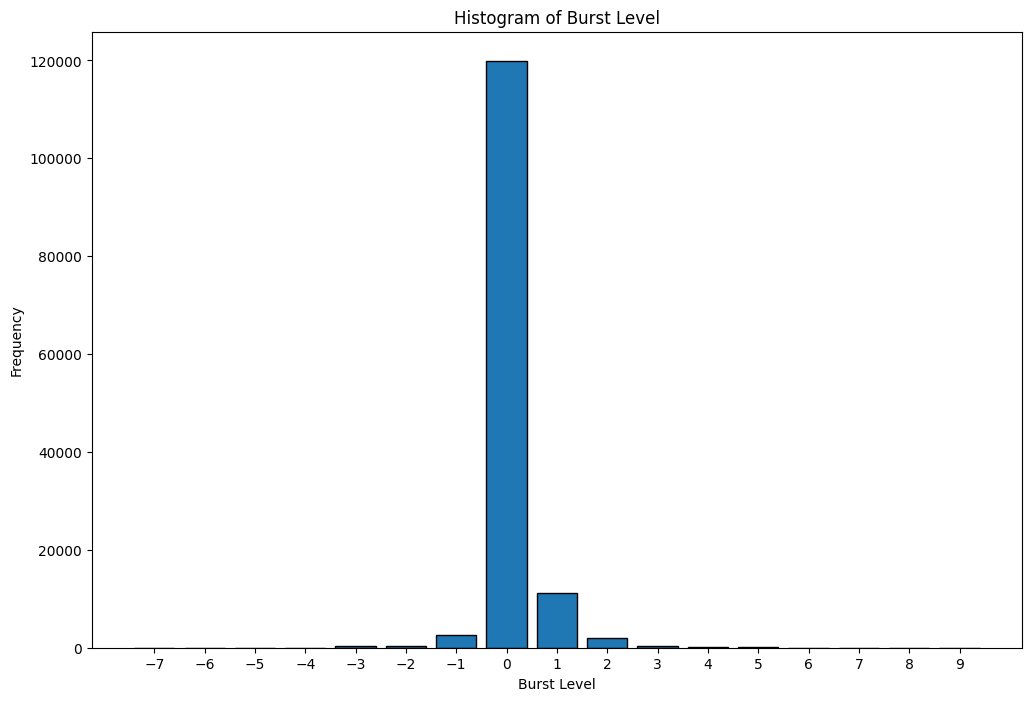

In [100]:
# Group data based on 'burst_lvl' and count occurrences
value_counts = result_df['burst_lvl'].value_counts()
# Sort by index (burst_lvl values) to maintain order
value_counts = value_counts.sort_index()
plt.close('all')
plt.figure(figsize=(12, 8))
# Create a bar plot
plt.bar(value_counts.index, value_counts.values, align='center', edgecolor='black')
plt.xlabel('Burst Level')
plt.ylabel('Frequency')
plt.title('Histogram of Burst Level')
# Set the x-axis labels to the index of value_counts
plt.xticks(value_counts.index)


plt.show()

In [101]:
result_df[result_df['burst_lvl'] == -7]

,price,amount,maker_side,market_timestamp,receive_timestamp,burst_lvl
62266,15.71,19.78,Bid,2023-06-13 12:30:01.259,2023-06-13 12:30:01.528,-7
62265,15.71,145.52,Bid,2023-06-13 12:30:01.259,2023-06-13 12:30:01.528,-7
62274,15.72,145.52,Bid,2023-06-13 12:30:01.457,2023-06-13 12:30:01.689,-7
119515,15.09,1.38,Bid,2023-06-13 18:17:32.770,2023-06-13 18:17:32.917,-7
119516,15.09,27.00,Bid,2023-06-13 18:17:32.772,2023-06-13 18:17:32.918,-7
119517,15.09,3.25,Bid,2023-06-13 18:17:32.774,2023-06-13 18:17:32.919,-7
119518,15.09,3.24,Bid,2023-06-13 18:17:32.777,2023-06-13 18:17:32.921,-7
119519,15.09,3.27,Bid,2023-06-13 18:17:32.778,2023-06-13 18:17:32.921,-7


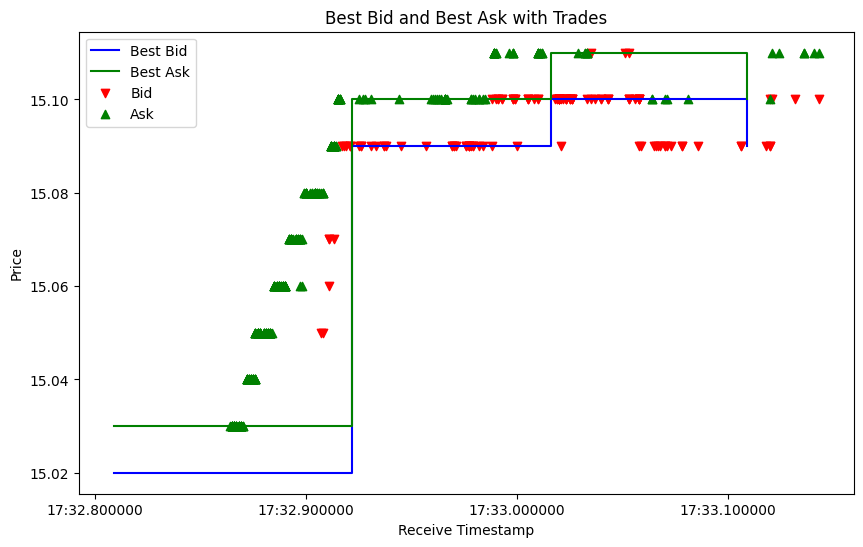

In [102]:
start_time = pd.to_datetime('2023-06-13  18:17:32.800	')
end_time = pd.to_datetime('2023-06-13  18:17:33.150	')

binance_filtered = binance[(binance['receive_timestamp'] >= start_time) & (binance['receive_timestamp'] <= end_time)]
binance_trades_filtered = binance_trades[(binance_trades['receive_timestamp'] >= start_time) & (binance_trades['receive_timestamp'] <= end_time)]

# Set a larger figure size
plt.figure(figsize=(10, 6))

plt.step(binance_filtered['receive_timestamp'], binance_filtered['best_bid'], where='post', label='Best Bid', color='blue')
plt.step(binance_filtered['receive_timestamp'], binance_filtered['best_ask'], where='post', label='Best Ask', color='green')

# Plot trades as red triangles down (Bid) and green triangles up (Ask)
bid_trades = binance_trades_filtered[binance_trades_filtered['maker_side'] == 'Bid']
ask_trades = binance_trades_filtered[binance_trades_filtered['maker_side'] == 'Ask']

plt.scatter(bid_trades['receive_timestamp'], bid_trades['price'], marker='v', color='red', label='Bid')
plt.scatter(ask_trades['receive_timestamp'], ask_trades['price'], marker='^', color='green', label='Ask')

plt.xlabel('Receive Timestamp')
plt.ylabel('Price')
plt.title('Best Bid and Best Ask with Trades')
plt.legend()

plt.show()


In [103]:
binance_trades

,price,amount,maker_side,market_timestamp,receive_timestamp
0,15.19,7.03,Ask,2023-06-13 00:00:01.066,2023-06-13 00:00:01.196
1,15.19,0.40,Ask,2023-06-13 00:00:04.710,2023-06-13 00:00:04.839
2,15.19,0.27,Ask,2023-06-13 00:00:04.710,2023-06-13 00:00:04.840
3,15.19,1.50,Ask,2023-06-13 00:00:05.503,2023-06-13 00:00:05.632
4,15.20,1.91,Ask,2023-06-13 00:00:05.503,2023-06-13 00:00:05.633
...,...,...,...,...,...
137377,15.04,13.29,Ask,2023-06-13 23:59:31.610,2023-06-13 23:59:31.740
137378,15.04,0.44,Ask,2023-06-13 23:59:53.601,2023-06-13 23:59:53.731
137379,15.04,8.54,Ask,2023-06-13 23:59:55.627,2023-06-13 23:59:55.757
137380,15.03,0.89,Bid,2023-06-13 23:59:57.511,2023-06-13 23:59:57.641


In [144]:

@jit(nopython=True)
def calculate_grid_values(prices, amounts, timestamps, grid_prices, r):
    n = len(prices)
    grid_len = len(grid_prices)
    grid_values_list = np.zeros((n, grid_len))

    previous_timestamp = timestamps[0]

    for i in range(n):
        current_tuple = np.zeros(grid_len)

        if i > 0:
            dt = (timestamps[i] - previous_timestamp) / (1000 * 3600)  # Convert to hours from milliseconds
            decay_factor = exp(-r * dt)

            # Apply the decay factor to the last tuple
            current_tuple = grid_values_list[i - 1] * decay_factor

        # Find the closest price index in the grid
        idx = np.searchsorted(grid_prices, prices[i])

        # Update the trade amount at the found index
        current_tuple[idx] += amounts[i]

        grid_values_list[i] = current_tuple

        # Update the previous timestamp
        previous_timestamp = timestamps[i]

    return grid_values_list

# Filter the trades
binance_trades_ask = binance_trades[binance_trades['maker_side'] == 'Ask']

# Create a grid of prices
tick_size = 0.01
grid_start = binance_trades_ask['price'].min() - 20 * tick_size
grid_end = binance_trades_ask['price'].max() + 20 * tick_size
grid_prices = np.arange(grid_start, grid_end, tick_size)

# External constant
r = 0.1  # Adjust as needed

# Extract numpy arrays for prices, amounts, and timestamps
prices = binance_trades_ask['price'].values
amounts = binance_trades_ask['amount'].values
timestamps = (pd.to_datetime(binance_trades_ask['market_timestamp']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')
timestamps = timestamps.values

# Calculate the grid values using the numba function
grid_values_arr = calculate_grid_values(prices, amounts, timestamps, grid_prices, r)


<ipython-input-145-365c2c2af33a>:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust the layout


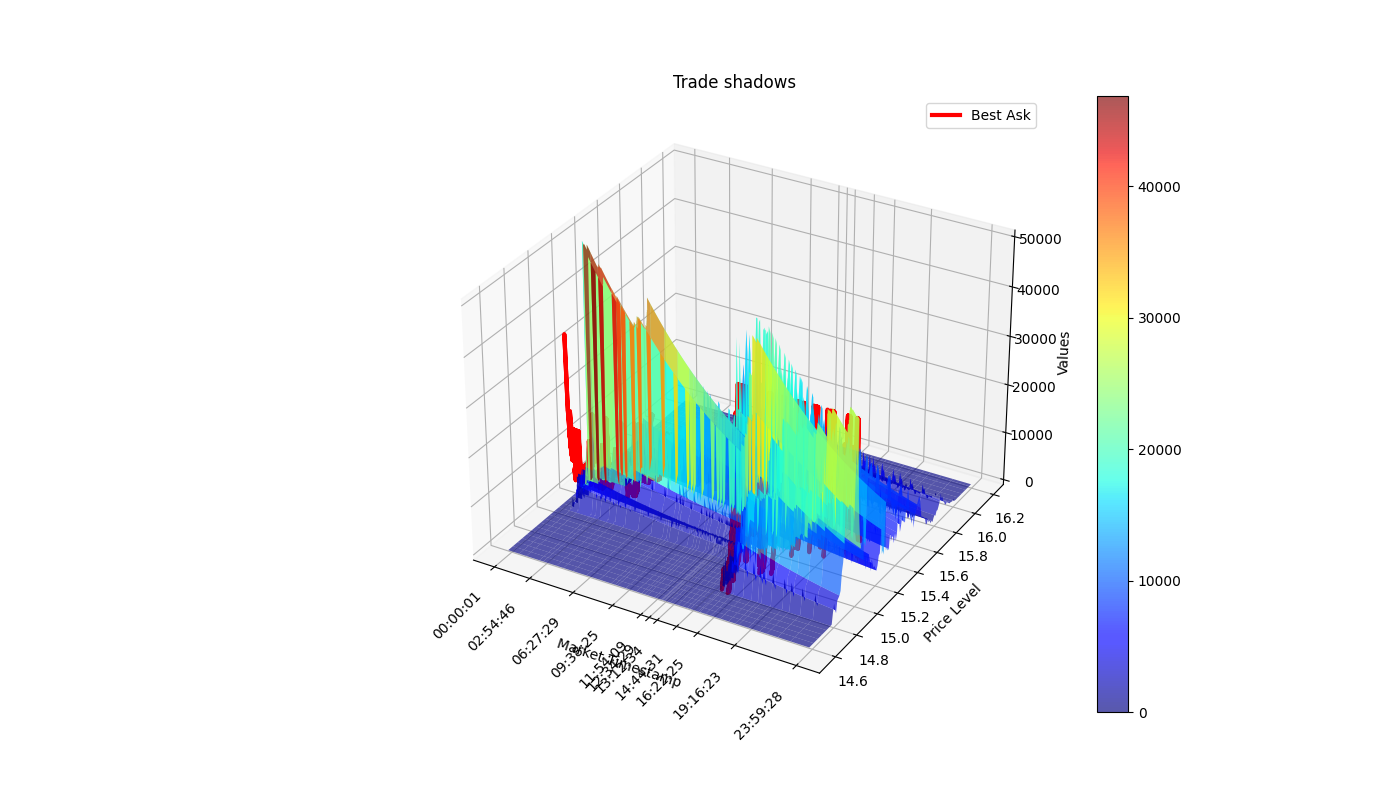

In [145]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure and 3D axis
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Use meshgrid to prepare the grid for the 3D plot
timestamps_mesh, grid_prices_mesh = np.meshgrid(timestamps, grid_prices)

# The Z values are taken from your grid_values_arr, but need to be transposed
# to match the X, Y meshgrid
Z = grid_values_arr.T

# Plot the surface
surf = ax.plot_surface(timestamps_mesh, grid_prices_mesh, Z, cmap='jet', alpha=0.65)

# Extract best_ask and its corresponding timestamps for the line plot
best_ask_timestamps = (pd.to_datetime(binance['receive_timestamp']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')
best_ask_timestamps = best_ask_timestamps.values
best_ask_prices = binance['best_ask'].values
best_ask_values = np.interp(best_ask_prices, grid_prices, grid_values_arr[-1])  # Interpolating values for best_ask prices from the last tuple

# Plot the best_ask as a wide red line
ax.plot(best_ask_timestamps, best_ask_prices, best_ask_values, color='red', linewidth=3, label='Best Ask')

# Label the axes
ax.set_xlabel('Market Timestamp')
ax.set_ylabel('Price Level')
ax.set_zlabel('Values')

# Adjust x-axis ticks to match market_timestamp values from binance_trades_ask dataframe
xticks_interval = len(timestamps) // 10
ax.set_xticks(timestamps[::xticks_interval])  # Reducing the number of x-ticks for clarity
labels = [(pd.Timestamp("1970-01-01") + pd.Timedelta(milliseconds=int(ts))).time().strftime('%H:%M:%S') for ts in timestamps[::xticks_interval]]
ax.set_xticklabels(labels, rotation=45, ha='right')

# Add a legend
ax.legend()
ax.set_title('Trade shadows')
# Add a color bar for better visualization
fig.colorbar(surf)

plt.tight_layout()  # Adjust the layout
plt.show()


In [126]:
binance_trades

,price,amount,maker_side,market_timestamp,receive_timestamp
0,15.19,7.03,Ask,2023-06-13 00:00:01.066,2023-06-13 00:00:01.196
1,15.19,0.40,Ask,2023-06-13 00:00:04.710,2023-06-13 00:00:04.839
2,15.19,0.27,Ask,2023-06-13 00:00:04.710,2023-06-13 00:00:04.840
3,15.19,1.50,Ask,2023-06-13 00:00:05.503,2023-06-13 00:00:05.632
4,15.20,1.91,Ask,2023-06-13 00:00:05.503,2023-06-13 00:00:05.633
...,...,...,...,...,...
137377,15.04,13.29,Ask,2023-06-13 23:59:31.610,2023-06-13 23:59:31.740
137378,15.04,0.44,Ask,2023-06-13 23:59:53.601,2023-06-13 23:59:53.731
137379,15.04,8.54,Ask,2023-06-13 23:59:55.627,2023-06-13 23:59:55.757
137380,15.03,0.89,Bid,2023-06-13 23:59:57.511,2023-06-13 23:59:57.641


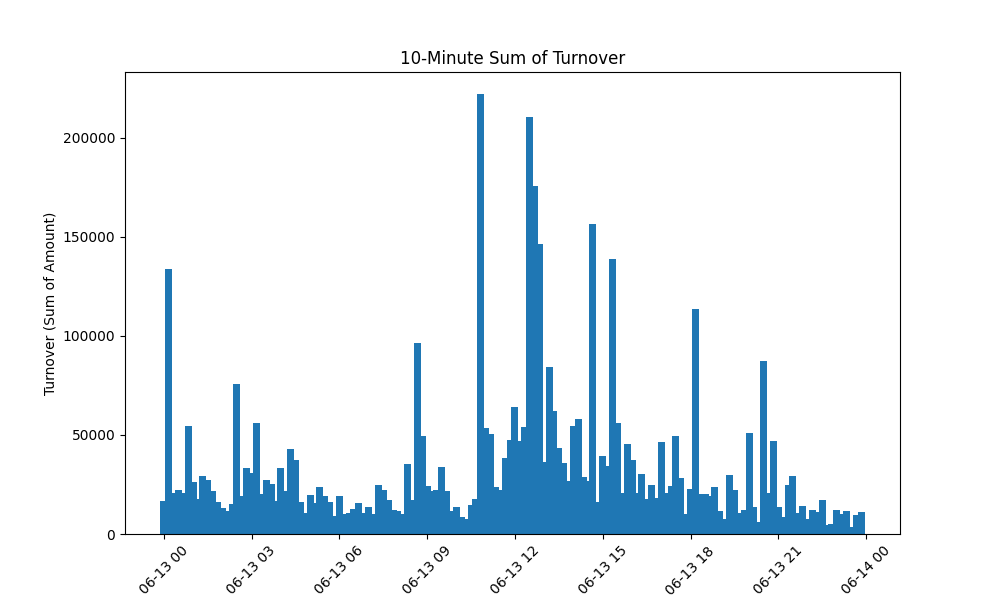

In [127]:

import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the 'binance_trades' DataFrame with the required columns.

# Convert 'receive_timestamp' to datetime objects
binance_trades['receive_timestamp'] = pd.to_datetime(binance_trades['receive_timestamp'])

# Set 'receive_timestamp' as the index
binance_trades.set_index('receive_timestamp', inplace=True)

# Resample data into 10-minute intervals and calculate the sum of turnover
turnover_10min = binance_trades['amount'].resample('10T').sum()

# Set a larger figure size
plt.figure(figsize=(10, 6))

# Create a bar chart for 10-minute sum of turnover
plt.bar(turnover_10min.index, turnover_10min.values, width=0.01)
plt.xlabel('Receive Timestamp (10-Minute Intervals)')
plt.ylabel('Turnover (Sum of Amount)')
plt.title('10-Minute Sum of Turnover')
plt.xticks(rotation=45)

plt.show()
